# GPL Paper Section 4.1.2 Experiment: Quadratic Hamiltonian with L1 Prior

This code attempts to learn 32D prior $J(x) = \|x\|_1$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian
$H(p) = \frac{1}{2}\|p\|_2^2$ (Using the method of characterization).
The LPN learns the function $\psi(y) = J^*(y) - \frac{1}{2}\|y\|_2^2$.
Training data uses samples $\{y_j,\psi(y_j)\}$ where $\psi(y_j) = \frac{1}{2}\|y_j\|_2^2 - S(y_j,1)$, and,
$S(y_j,1) = \min_{x \in \mathbb{R}^d} \{\frac{1}{2}\|x-y_j\|_2^2 + \|x\|_1\}$ (Moreau envelope of $J(x)=\|x\|_1$ at $t=1$).

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_4_1_2_quadratic_32D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

In [2]:
# Parameters
# --- Parameters for Sec 4.1.2 L1 Prior Experiment ---
dim_exp = 32  # Dimension (e.g., 2D, 4D, 8D as in the paper)
data_points_exp = 20000 # Example number of data points
iterations_exp_initial = 1 # Iterations for initial training phase
iterations_exp_long = 500000 # Iterations for longer training phase
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 50 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 10       # beta of softplus
hidden = 128     # number of hidden units
layers = 8      # number of layers
eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

# === Section 4.1.2===

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Section 4.1.2: L1 Prior Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)

def prox_l1_vec(y, t_lambda):
    """ Element-wise proximal operator of t_lambda*||x||_1 (soft-thresholding). """
    return np.sign(y) * np.maximum(np.abs(y) - t_lambda, 0)

def hjsol_true_quadratic_l1(y_points,n=1.0, t=1.0): # y_points is N x dim
    """
    Computes S(y, t=1) for J(x)=||x||_1.
    S(y, 1) = ||x||_1 + nt/2 }
    """
    t_moreau = 1.0
    prox_y = prox_l1_vec(y_points, t_moreau) # element-wise for N x dim
    s_values = np.sum(np.abs(prox_y), axis=1) +n * t/2 # L1 norm for each vector y_j 
    return s_values # N-dimensional array

def prior_true_quadratic_l1(y_points): # y_points is N x dim
    """ Computes the true prior J(y) = ||y||_1. """
    return np.sum(np.abs(y_points), axis=1) # N-dimensional array

def cvx_true_quadratic_l1(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = 0.5*||y||_2^2 - S(y, t=1) for J(x)=||x||_1.
    """
    s_y_1 = hjsol_true_quadratic_l1(y_points)
    psi_y = 0.5 * euclid_norm_sq(y_points) - s_y_1
    return psi_y # N-dimensional array

# def invert_prior_lpn(x, model, INVERT_MODE):
#     y = invert(x,model,INVERT_MODE)
#     return y

# def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
#     try:
#         y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
#         psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
#     except NameError: 
#         print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
#         y_tensor = torch.from_numpy(y_inverted_points).float()
#         psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
#     prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
#     return prior_est


def evaluate_learned_J_HJ_approx(x_eval_points_np, model, t_val=1.0):
    """
    Evaluates the learned prior J_est(x) using the LPN and HJ approximation.
    J(x) ≈ S(x + t*grad_S(x,t), t) - (t/2)*||grad_S(x,t)||^2
    where S(x,t) = (1/2t)||x||^2 - (1/t)psi_t(x) if LPN learns psi_t(x).
    Here, LPN learns psi(x) which is psi_1(x), so we use t=1.
    S(x,1) = 0.5*||x||^2 - psi(x)
    grad_S(x,1) = x - grad_psi(x)
    
    Args:
        x_eval_points_np (np.ndarray): N x dim array of points to estimate J(x) at.
        model: The trained LPN model object (e.g., a torch.nn.Module).
        t_val (float): Time parameter, typically 1.0 for this setup.
    
    Returns:
        np.ndarray: N-dimensional array of estimated prior values J_est(x_eval_points).
    """
    x_tensor = torch.from_numpy(x_eval_points_np).float().to(device)
    x_tensor.requires_grad_(True)  # Ensure grad can be computed
    
    # grad_psi_x = nabla_psi(x)
    # The LPN's forward() method (model(x_tensor)) should return nabla_psi(x)
    grad_psi_x_tensor = model(x_tensor) 
    
    # p_eval = nabla_S(x,1) = x - nabla_psi(x)
    p_eval_tensor = x_tensor - grad_psi_x_tensor
    
    # x_new = x + t * p_eval
    x_new_tensor = x_tensor + t_val * p_eval_tensor
    
    # psi_x_new = psi(x_new)
    psi_x_new_tensor = model.scalar(x_new_tensor)  # Should be N x 1
    
    # S(x_new, 1) = 0.5*||x_new||^2 - psi(x_new)
    norm_sq_x_new_tensor = torch.sum(x_new_tensor**2, dim=1, keepdim=True)  # N x 1
    S_x_new_t_tensor = 0.5 * norm_sq_x_new_tensor - psi_x_new_tensor  # N x 1
    
    # (t/2)*||p_eval||^2
    norm_sq_p_eval_tensor = torch.sum(p_eval_tensor**2, dim=1, keepdim=True)  # N x 1
    term2_tensor = (t_val / 2.0) * norm_sq_p_eval_tensor  # N x 1
    
    J_approx_tensor = S_x_new_t_tensor - term2_tensor  # N x 1
    
    return J_approx_tensor.detach().cpu().numpy().flatten()  # N-dimensional

def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_quadratic_l1(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_quadratic_l1(x1_0_points)
    x1_0_J_true = prior_true_quadratic_l1(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_quadratic_l1(x2_0_points)
        x2_0_J_true = prior_true_quadratic_l1(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    #y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_J_HJ_approx(x1_0_points, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        #y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_J_HJ_approx(x2_0_points, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$y_1$')
    plt.ylabel('$\\psi(y_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
        plt.xlabel('$y_2$')
        plt.ylabel('$\\psi(0,y_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=\\|x\\|_1$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_quadratic_l1(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, L1 Prior (Dim={dim}) ---")
    cross_sections_plots_quadratic_l1(model, a, spacing, INVERT_MODE, dim)



In [4]:

def exp_func(x, gamma):
    # Ensure x is a 1D tensor for vector_norm if it comes in as N x 1
    if x.ndim > 1 and x.shape[1] == 1:
        x = x.squeeze(1)
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim=-1)/ gamma) ** 2)) + 1.0


# --- Generate Training Data (using Moreau envelope target as per notebook) ---

In [5]:
# --- Generate Training Data ---
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))

cvx_samples_exp_np = cvx_true_quadratic_l1(y_j_exp_np)
cvx_samples_exp_np = cvx_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float()
cvx_samples_exp_tensor = torch.from_numpy(cvx_samples_exp_np).float()
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, cvx_samples_exp_tensor shape {cvx_samples_exp_tensor.shape}")
# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_exp_tensor = y_j_exp_tensor.to(device)
cvx_samples_exp_tensor = cvx_samples_exp_tensor.to(device)

Generated training data: y_j_exp_tensor shape torch.Size([20000, 32]), cvx_samples_exp_tensor shape torch.Size([20000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:

print("--- Training LPN for J(x)=||x||_1 (Quadratic H) ---")
lpn_model_quad_l2 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_quad_l2 = torch.optim.Adam(lpn_model_quad_l2.parameters(), lr=1e-4)

for i in range(iterations_exp_initial):
     single_iteration(i, data_points_exp, lpn_model_quad_l2, optimizer_quad_l2, y_j_exp_tensor,cvx_samples_exp_tensor,loss_type=2,gamma_loss=None)

for g in optimizer_quad_l2.param_groups:
    g["lr"] = 1e-4 
for i in range(iterations_exp_long):
    single_iteration(i, data_points_exp, lpn_model_quad_l2, optimizer_quad_l2, y_j_exp_tensor,cvx_samples_exp_tensor,loss_type=2,gamma_loss=None)

torch.save(lpn_model_quad_l2.state_dict(), os.path.join(MODEL_DIR, "QuadraticH_L1prior_l2.pth"))

--- Training LPN for J(x)=||x||_1 (Quadratic H) ---


iteration 0 loss 2463.5546875
iteration 0 loss 45421536.0


iteration 5000 loss 854.9513549804688


iteration 10000 loss 20.82046127319336


iteration 15000 loss 16.228252410888672


iteration 20000 loss 7.7823052406311035


iteration 25000 loss 0.1481238752603531


iteration 30000 loss 0.04980658367276192


iteration 35000 loss 0.026999937370419502


iteration 40000 loss 0.01622769981622696


iteration 45000 loss 0.010542429983615875


iteration 50000 loss 0.006978228688240051


iteration 55000 loss 0.004769660532474518


iteration 60000 loss 0.008282376453280449


iteration 65000 loss 0.0024934851098805666


iteration 70000 loss 0.001777082565240562


iteration 75000 loss 0.0014344291994348168


iteration 80000 loss 0.004114770330488682


iteration 85000 loss 0.00079346977872774


iteration 90000 loss 0.056025292724370956


iteration 95000 loss 0.0005049448227509856


iteration 100000 loss 0.0329756997525692


iteration 105000 loss 0.00033621478360146284


iteration 110000 loss 0.00028670227038674057


iteration 115000 loss 0.004992270842194557


iteration 120000 loss 0.00021111068781465292


iteration 125000 loss 0.00017369176202919334


iteration 130000 loss 0.0001666681928327307


iteration 135000 loss 0.008599081076681614


iteration 140000 loss 0.00046574295265600085


iteration 145000 loss 0.00014042954717297107


iteration 150000 loss 0.00011618845019256696


iteration 155000 loss 0.00010815716814249754


iteration 160000 loss 0.00010163225670112297


iteration 165000 loss 0.017621347680687904


iteration 170000 loss 0.04154448211193085


iteration 175000 loss 8.709329995326698e-05


iteration 180000 loss 8.101465209620073e-05


iteration 185000 loss 7.935045141493902e-05


iteration 190000 loss 9.087015496334061e-05


iteration 195000 loss 0.00012537538714241236


iteration 200000 loss 7.150117016863078e-05


iteration 205000 loss 0.00031292624771595


iteration 210000 loss 7.014171569608152e-05


iteration 215000 loss 0.0188603512942791


iteration 220000 loss 7.121127418940887e-05


iteration 225000 loss 0.00033442993299104273


iteration 230000 loss 6.887732888571918e-05


iteration 235000 loss 7.756516424706206e-05


iteration 240000 loss 6.913287506904453e-05


iteration 245000 loss 0.36058321595191956


iteration 250000 loss 0.0001890519488370046


iteration 255000 loss 6.92668036208488e-05


iteration 260000 loss 6.365318404277787e-05


iteration 265000 loss 5.8241639635525644e-05


iteration 270000 loss 0.0029082419350743294


iteration 275000 loss 0.017589149996638298


iteration 280000 loss 0.0338386707007885


iteration 285000 loss 0.0007458208710886538


iteration 290000 loss 5.370415237848647e-05


iteration 295000 loss 9.326665167463943e-05


iteration 300000 loss 6.0216836573090404e-05


iteration 305000 loss 0.35098251700401306


iteration 310000 loss 0.0001681080466369167


iteration 315000 loss 0.021699728444218636


iteration 320000 loss 0.00012165655789431185


iteration 325000 loss 0.00031769007910043


iteration 330000 loss 0.002771934727206826


iteration 335000 loss 4.75161723443307e-05


iteration 340000 loss 0.027189532294869423


iteration 345000 loss 5.6299428251804784e-05


iteration 350000 loss 0.013539852574467659


iteration 355000 loss 0.03341502696275711


iteration 360000 loss 0.2975238561630249


iteration 365000 loss 0.005530705209821463


iteration 370000 loss 0.0006631799624301493


iteration 375000 loss 4.579343294608407e-05


iteration 380000 loss 4.9354151997249573e-05


iteration 385000 loss 4.84093397972174e-05


iteration 390000 loss 0.010853312909603119


iteration 395000 loss 5.9809492086060345e-05


iteration 400000 loss 5.0760638259816915e-05


iteration 405000 loss 0.08615812659263611


iteration 410000 loss 0.018345411866903305


iteration 415000 loss 4.612035627360456e-05


iteration 420000 loss 8.173708920367062e-05


iteration 425000 loss 0.0004724660830106586


iteration 430000 loss 4.4536242057802156e-05


iteration 435000 loss 3.994463259004988e-05


iteration 440000 loss 0.00011915747745661065


iteration 445000 loss 4.9330719775753096e-05


iteration 450000 loss 4.15432768932078e-05


iteration 455000 loss 5.036247966927476e-05


iteration 460000 loss 0.00011793504381785169


iteration 465000 loss 0.040117714554071426


iteration 470000 loss 0.0003386704484000802


iteration 475000 loss 3.7713904021074995e-05


iteration 480000 loss 0.1361016035079956


iteration 485000 loss 3.913724503945559e-05


iteration 490000 loss 0.0009292024187743664


iteration 495000 loss 0.025226542726159096


L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, L1 Prior (Dim=32) ---


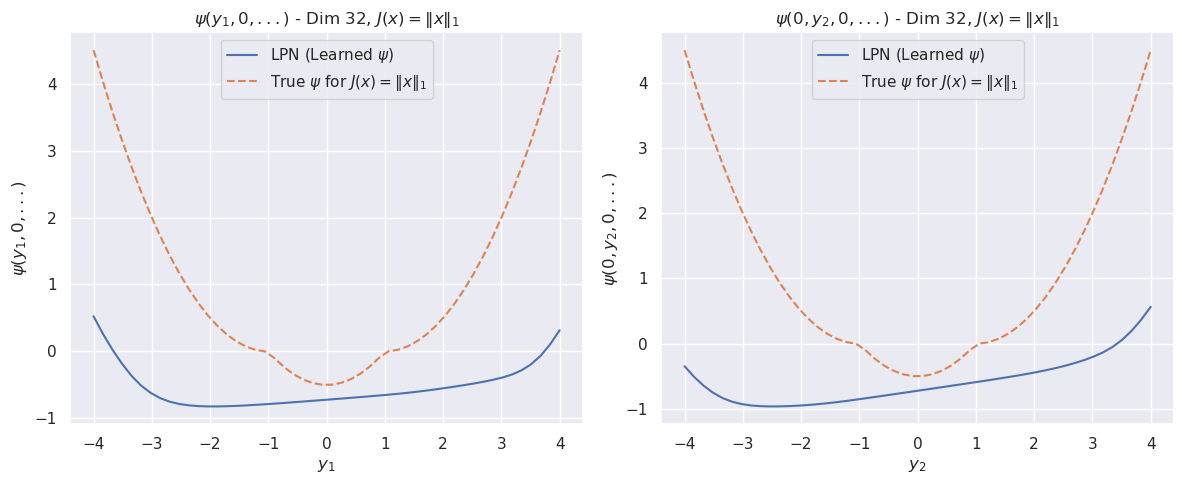

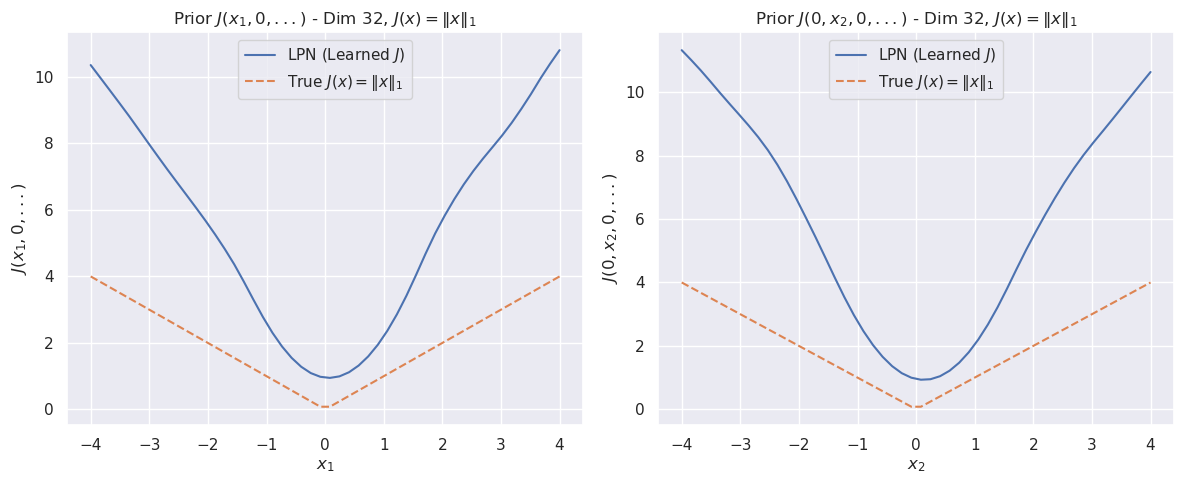

In [8]:
# L2 loss -- Plot
plot_all_quadratic_l1(lpn_model_quad_l2, a_exp, spacing, INVERT_MODE, dim_exp)

Generated G samples: G_samples_tensor shape torch.Size([20000, 1])

--- Plotting Updated Prior j_hat(y) (Dim=32) ---


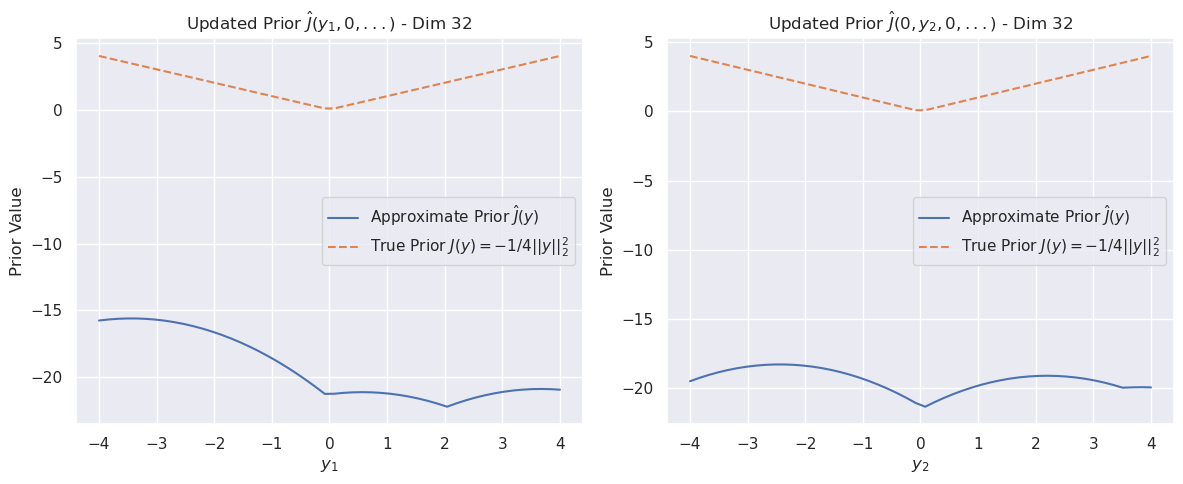

In [9]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone()
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_quad_l2.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_quad_l2(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach() 

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")


def evaluate_updated_prior_J_hat(y_points, model, x_k_np):
    """
    Implements the approximate prior.
    """
    
    # Pre-compute y_k = grad psi(x_k) from the training data
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    y_k_tensor = model(x_k_tensor)
    y_k_np = y_k_tensor.detach().cpu().numpy()
    
    # Compute S(x_k, 1) = psi(x_k, t=1) from the LPN
    S_x_k = model.scalar(x_k_tensor)  # Shape (K, 1)
    S_x_k_np = S_x_k.detach().cpu().numpy().flatten()  # Shape (K,)
    
    # The constant term simplifies to just S(x_k, 1)
    # Because: J_tilde(y_k) + 1/2||x_k - y_k||^2 
    #        = [S(x_k,1) - 1/2||x_k - y_k||^2] + 1/2||x_k - y_k||^2 
    #        = S(x_k, 1)
    constants_k = S_x_k_np  # Shape (K,)
    
    # Term 3: -1/2 * ||x_k - y||^2
    # Broadcasting: x_k_np (K, 1, dim), y_points (1, N, dim) -> (K, N)
    term3 = -0.5 * np.sum((x_k_np[:, np.newaxis, :] - y_points[np.newaxis, :, :])**2, axis=2)
    
    # Term 4: 1/4 * ||y - y_k||^2
    # Broadcasting: y_points (1, N, dim), y_k_np (K, 1, dim) -> (K, N)
    term4 = 0.25 * np.sum((y_points[np.newaxis, :, :] - y_k_np[:, np.newaxis, :])**2, axis=2)

    term5 = 0.5 * np.sum((x_k_np[:, np.newaxis, :])**2, axis=2)
    all_terms = term5 - constants_k[:, np.newaxis] + term3 
    
    # # Combine all terms: constants_k (K, 1) + term3 (K, N) + term4 (K, N)
    # all_terms = constants_k[:, np.newaxis] + term3 + term4
    
    # Take the max over K dimension
    j_hat_est = np.max(all_terms, axis=0)
    
    return j_hat_est

def plot_updated_prior_J_hat(model, a, spacing, dim, x_k_np):
    """
    Generates cross-section plots for the prior j_hat(y) from the "Update".
    """
    print(f"\n--- Plotting Updated Prior j_hat(y) (Dim={dim}) ---")
    xi, y1_0_points, y2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute true prior J(y)
    y1_0_J_true = prior_true_quadratic_l1(y1_0_points)
    
    # Compute estimated prior j_hat(y)
    y1_0_J_hat_est = evaluate_updated_prior_J_hat(y1_0_points, model, x_k_np)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, y1_0_J_hat_est, "-", label="Approximate Prior $\\hat{J}(y)$")
    plt.plot(xi, y1_0_J_true, "--", label="True Prior $J(y)=-1/4||y||_2^2$")
    plt.grid(True)
    plt.title(f"Updated Prior $\\hat{{J}}(y_1,0,...)$ - Dim {dim}")
    plt.xlabel('$y_1$')
    plt.ylabel('Prior Value')
    plt.legend()

    if dim > 1:
        y2_0_J_true = prior_true_quadratic_l1(y2_0_points)
        y2_0_J_hat_est = evaluate_updated_prior_J_hat(y2_0_points, model, x_k_np)
        
        plt.subplot(1, 2, 2)
        plt.plot(xi, y2_0_J_hat_est, "-", label="Approximate Prior $\\hat{J}(y)$")
        plt.plot(xi, y2_0_J_true, "--", label="True Prior $J(y)=-1/4||y||_2^2$")
        plt.grid(True)
        plt.title(f"Updated Prior $\\hat{{J}}(0,y_2,0,...)$ - Dim {dim}")
        plt.xlabel('$y_2$')
        plt.ylabel('Prior Value')
        plt.legend()
        
    plt.tight_layout()
    plt.show()


# We use the original training data 'x_j_exp_np' as our set of x_k points.
#subset_size = 1000 
x_k_subset_np = y_j_exp_np#[:subset_size, :]

plot_updated_prior_J_hat(lpn_model_quad_l2, a_exp, spacing, dim_exp, x_k_subset_np)


In [10]:
# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(iterations_exp_initial):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 # Use a smaller learning rate for the long phase
for i in range(iterations_exp_long):
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 2390.064697265625
iteration 0 loss 8255446.0


iteration 5000 loss 14.67231559753418


iteration 10000 loss 5.3883891105651855


iteration 15000 loss 2.0642144680023193


iteration 20000 loss 1.0134539604187012


iteration 25000 loss 0.20336543023586273


iteration 30000 loss 0.09548649936914444


iteration 35000 loss 0.05977793410420418


iteration 40000 loss 0.04124382138252258


iteration 45000 loss 0.03098653256893158


iteration 50000 loss 0.024245548993349075


iteration 55000 loss 0.01940414123237133


iteration 60000 loss 0.015945788472890854


iteration 65000 loss 0.013191022910177708


iteration 70000 loss 0.011007793247699738


iteration 75000 loss 0.009294984862208366


iteration 80000 loss 0.007929727435112


iteration 85000 loss 0.006817614659667015


iteration 90000 loss 0.005902185570448637


iteration 95000 loss 0.005230045411735773


iteration 100000 loss 0.004515181761234999


iteration 105000 loss 0.003961552400141954


iteration 110000 loss 0.1912253350019455


iteration 115000 loss 0.00311179063282907


iteration 120000 loss 0.005113496910780668


iteration 125000 loss 0.0025251952465623617


iteration 130000 loss 0.0022361313458532095


iteration 135000 loss 0.001999491360038519


iteration 140000 loss 0.0018005010206252337


iteration 145000 loss 0.0016247493913397193


iteration 150000 loss 0.0014821803197264671


iteration 155000 loss 0.0019650172907859087


iteration 160000 loss 0.0012189432745799422


iteration 165000 loss 0.0011088146129623055


iteration 170000 loss 0.0030026109889149666


iteration 175000 loss 0.0009260274819098413


iteration 180000 loss 0.0008583110757172108


iteration 185000 loss 0.0007763411267660558


iteration 190000 loss 0.0007149641751311719


iteration 195000 loss 0.001667009317316115


iteration 200000 loss 0.0006083526532165706


iteration 205000 loss 0.041046835482120514


iteration 210000 loss 0.0005212210235185921


iteration 215000 loss 0.00048384760157205164


iteration 220000 loss 0.0004435656301211566


iteration 225000 loss 0.00041141375550068915


iteration 230000 loss 0.0005904373829253018


iteration 235000 loss 0.00035944677074439824


iteration 240000 loss 0.0007797173457220197


iteration 245000 loss 0.0003098916495218873


iteration 250000 loss 0.0002911146148107946


iteration 255000 loss 0.0002733245200943202


iteration 260000 loss 0.00025406660279259086


iteration 265000 loss 0.0002414930349914357


iteration 270000 loss 0.00022521833307109773


iteration 275000 loss 0.09001632034778595


iteration 280000 loss 0.0002142965968232602


iteration 285000 loss 0.0001895318564493209


iteration 290000 loss 0.0001773889089236036


iteration 295000 loss 0.00017920436221174896


iteration 300000 loss 0.00016195792704820633


iteration 305000 loss 0.0006453465321101248


iteration 310000 loss 0.0003271041205152869


iteration 315000 loss 0.0001378429587930441


iteration 320000 loss 0.000650731788482517


iteration 325000 loss 0.00012513113324530423


iteration 330000 loss 0.0011769220000132918


iteration 335000 loss 0.00013722719450015575


iteration 340000 loss 0.0001082344533642754


iteration 345000 loss 0.00010236786329187453


iteration 350000 loss 0.20997309684753418


iteration 355000 loss 0.009156346321105957


iteration 360000 loss 0.023287104442715645


iteration 365000 loss 8.656209683977067e-05


iteration 370000 loss 8.606837945990264e-05


iteration 375000 loss 0.00016300048446282744


iteration 380000 loss 0.004820203874260187


iteration 385000 loss 7.599855598527938e-05


iteration 390000 loss 7.324305624933913e-05


iteration 395000 loss 7.09027299308218e-05


iteration 400000 loss 6.859979475848377e-05


iteration 405000 loss 0.0011154066305607557


iteration 410000 loss 6.490513624157757e-05


iteration 415000 loss 6.340033723972738e-05


iteration 420000 loss 6.195550668053329e-05


iteration 425000 loss 5.9820489695994183e-05


iteration 430000 loss 5.863326805410907e-05


iteration 435000 loss 5.757468898082152e-05


iteration 440000 loss 5.652259278576821e-05


iteration 445000 loss 6.698224024148658e-05


iteration 450000 loss 0.003929844591766596


iteration 455000 loss 0.0076249707490205765


iteration 460000 loss 0.020613254979252815


iteration 465000 loss 5.1283113862155005e-05


iteration 470000 loss 5.2274692279752344e-05


iteration 475000 loss 0.008421325124800205


iteration 480000 loss 5.1626673666760325e-05


iteration 485000 loss 4.7302761231549084e-05


iteration 490000 loss 7.324249600060284e-05


iteration 495000 loss 4.626106601790525e-05


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


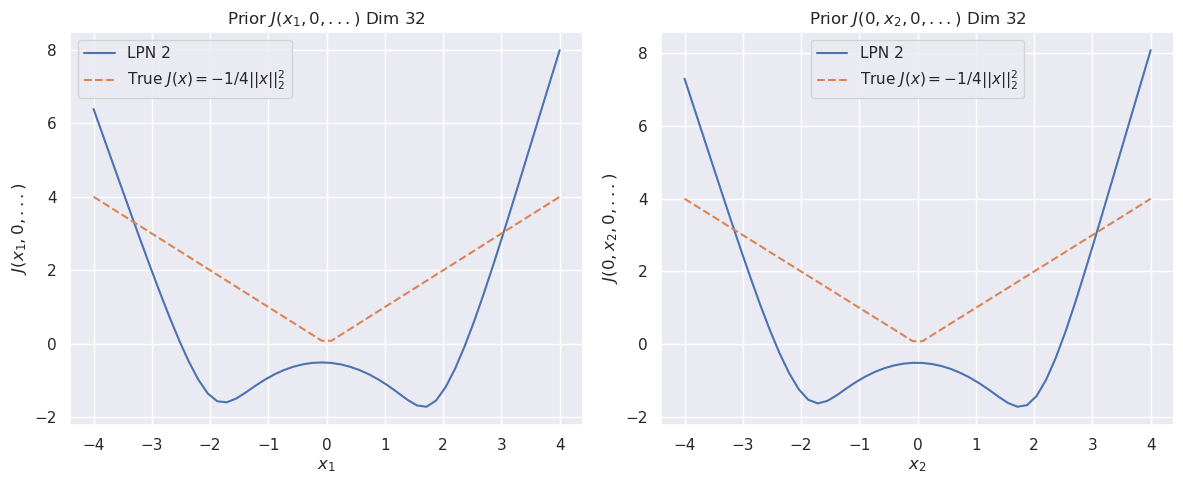

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_quadratic_l1(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_quadratic_l1(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
   # plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)

L1 loss -- Train

In [12]:

print("--- Training LPN for J(x)=||x||_1 (Quadratic H) ---")
lpn_model_quad_l1 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_quad_l1 = torch.optim.Adam(lpn_model_quad_l1.parameters(), lr=1e-4)

for i in range(iterations_exp_initial):
     single_iteration(i, data_points_exp, lpn_model_quad_l1, optimizer_quad_l1, y_j_exp_tensor,cvx_samples_exp_tensor,loss_type=1,gamma_loss=None)

for g in optimizer_quad_l1.param_groups:
    g["lr"] = 1e-4 
for i in range(iterations_exp_long):
    single_iteration(i, data_points_exp, lpn_model_quad_l1, optimizer_quad_l1, y_j_exp_tensor,cvx_samples_exp_tensor,loss_type=1,gamma_loss=None)

torch.save(lpn_model_quad_l1.state_dict(), os.path.join(MODEL_DIR, "QuadraticH_L1prior_l1.pth"))

--- Training LPN for J(x)=||x||_1 (Quadratic H) ---
iteration 0 loss 48.812068939208984
iteration 0 loss 6529.86865234375


iteration 5000 loss 2.8115897178649902


iteration 10000 loss 0.5795893669128418


iteration 15000 loss 0.3314986228942871


iteration 20000 loss 0.25227466225624084


iteration 25000 loss 0.2638668715953827


iteration 30000 loss 0.1838713139295578


iteration 35000 loss 0.32612958550453186


iteration 40000 loss 0.17295201122760773


iteration 45000 loss 0.16976580023765564


iteration 50000 loss 0.15063519775867462


iteration 55000 loss 0.1885581910610199


iteration 60000 loss 0.26625433564186096


iteration 65000 loss 0.26772427558898926


iteration 70000 loss 0.09896383434534073


iteration 75000 loss 0.1953752636909485


iteration 80000 loss 0.19077366590499878


iteration 85000 loss 0.10523228347301483


iteration 90000 loss 0.08231253176927567


iteration 95000 loss 0.2608242332935333


iteration 100000 loss 0.1770963817834854


iteration 105000 loss 0.21435365080833435


iteration 110000 loss 0.24486376345157623


iteration 115000 loss 0.21276679635047913


iteration 120000 loss 0.25945979356765747


iteration 125000 loss 0.11443862318992615


iteration 130000 loss 0.20763559639453888


iteration 135000 loss 0.19440986216068268


iteration 140000 loss 0.15115894377231598


iteration 145000 loss 0.16238032281398773


iteration 150000 loss 0.18714392185211182


iteration 155000 loss 0.23093651235103607


iteration 160000 loss 0.1484050452709198


iteration 165000 loss 0.2563549876213074


iteration 170000 loss 0.1607091873884201


iteration 175000 loss 0.17992368340492249


iteration 180000 loss 0.2556121051311493


iteration 185000 loss 0.26097244024276733


iteration 190000 loss 0.1406756192445755


iteration 195000 loss 0.08255723118782043


iteration 200000 loss 0.16816401481628418


iteration 205000 loss 0.11431955546140671


iteration 210000 loss 0.1627408117055893


iteration 215000 loss 0.08238852769136429


iteration 220000 loss 0.1697099506855011


iteration 225000 loss 0.16786979138851166


iteration 230000 loss 0.20670658349990845


iteration 235000 loss 0.060902684926986694


iteration 240000 loss 0.18551522493362427


iteration 245000 loss 0.11516787111759186


iteration 250000 loss 0.07900075614452362


iteration 255000 loss 0.17227184772491455


iteration 260000 loss 0.22998371720314026


iteration 265000 loss 0.12939931452274323


iteration 270000 loss 0.2886049151420593


iteration 275000 loss 0.25849461555480957


iteration 280000 loss 0.681856632232666


iteration 285000 loss 0.402771532535553


iteration 290000 loss 0.1214682012796402


iteration 295000 loss 0.3885570764541626


iteration 300000 loss 0.15286654233932495


iteration 305000 loss 0.1314193457365036


iteration 310000 loss 0.04561896249651909


iteration 315000 loss 0.1893870234489441


iteration 320000 loss 0.10918568819761276


iteration 325000 loss 0.10530180484056473


iteration 330000 loss 0.09876387566328049


iteration 335000 loss 0.08016961812973022


iteration 340000 loss 0.1331942230463028


iteration 345000 loss 0.1184908077120781


iteration 350000 loss 0.07225774973630905


iteration 355000 loss 0.3470456600189209


iteration 360000 loss 0.1685299426317215


iteration 365000 loss 0.12807616591453552


iteration 370000 loss 0.06945528835058212


iteration 375000 loss 0.22003768384456635


iteration 380000 loss 0.11872033029794693


iteration 385000 loss 0.16451965272426605


iteration 390000 loss 0.07240500301122665


iteration 395000 loss 0.06038494035601616


iteration 400000 loss 0.21332870423793793


iteration 405000 loss 0.18901506066322327


iteration 410000 loss 0.060870714485645294


iteration 415000 loss 0.3480888605117798


iteration 420000 loss 0.286100834608078


iteration 425000 loss 0.1535622775554657


iteration 430000 loss 0.3671407699584961


iteration 435000 loss 0.21432572603225708


iteration 440000 loss 0.07556787133216858


iteration 445000 loss 0.21330322325229645


iteration 450000 loss 0.2696610391139984


iteration 455000 loss 0.22650280594825745


iteration 460000 loss 0.1666276752948761


iteration 465000 loss 0.2260926514863968


iteration 470000 loss 0.04564379155635834


iteration 475000 loss 0.09397348761558533


iteration 480000 loss 0.5007967352867126


iteration 485000 loss 0.1307101547718048


iteration 490000 loss 0.21661986410617828


iteration 495000 loss 0.11042225360870361


L1 loss -- Plot


--- Plotting Cross Sections for Quadratic H, L1 Prior (Dim=32) ---


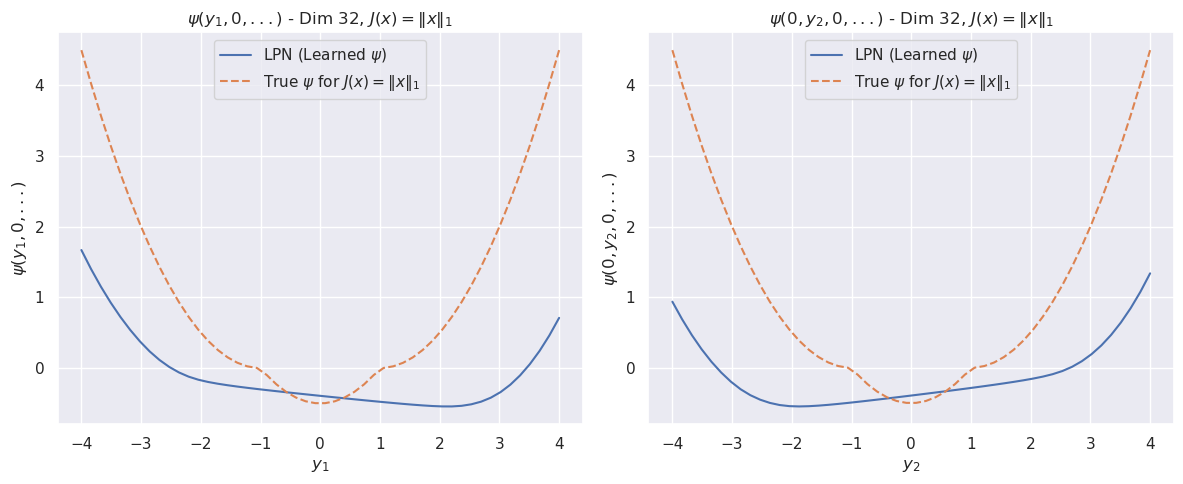

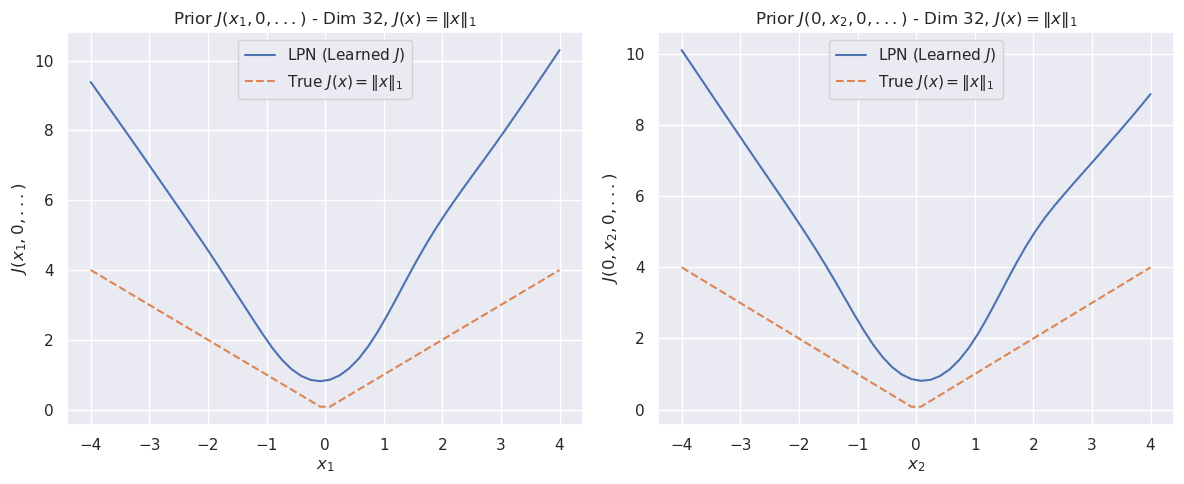

In [13]:
# L1 loss -- Plot
plot_all_quadratic_l1(lpn_model_quad_l1, a_exp, spacing, INVERT_MODE, dim_exp)


In [14]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_quad_l1.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_quad_l1(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")

# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(iterations_exp_initial):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 
for i in range(iterations_exp_long):
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")

Generated G samples: G_samples_tensor shape torch.Size([20000, 1])

--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 2259.93505859375
iteration 0 loss 11105417.0


iteration 5000 loss 37.17922592163086


iteration 10000 loss 6.707846641540527


iteration 15000 loss 3.078259229660034


iteration 20000 loss 1.5517857074737549


iteration 25000 loss 0.17204247415065765


iteration 30000 loss 0.0746481865644455


iteration 35000 loss 0.04342004284262657


iteration 40000 loss 0.029014073312282562


iteration 45000 loss 0.02106573060154915


iteration 50000 loss 0.015862835571169853


iteration 55000 loss 0.012471811845898628


iteration 60000 loss 0.00997497420758009


iteration 65000 loss 0.008081890642642975


iteration 70000 loss 0.00659731263294816


iteration 75000 loss 0.005477351136505604


iteration 80000 loss 0.0045822998508811


iteration 85000 loss 0.00384267489425838


iteration 90000 loss 0.0032619237899780273


iteration 95000 loss 0.0027924510650336742


iteration 100000 loss 0.0024133266415446997


iteration 105000 loss 0.0020932520274072886


iteration 110000 loss 0.0018311456078663468


iteration 115000 loss 0.001597317517735064


iteration 120000 loss 0.0014014572370797396


iteration 125000 loss 0.001244981773197651


iteration 130000 loss 0.00111045700032264


iteration 135000 loss 0.0009768663439899683


iteration 140000 loss 0.0008676440920680761


iteration 145000 loss 0.0007769378134980798


iteration 150000 loss 0.0007175228674896061


iteration 155000 loss 0.000629396119620651


iteration 160000 loss 0.0005796383484266698


iteration 165000 loss 0.3239693343639374


iteration 170000 loss 0.0004608145682141185


iteration 175000 loss 0.0004163487465120852


iteration 180000 loss 0.00043418025597929955


iteration 185000 loss 0.0005221562460064888


iteration 190000 loss 0.001131553784944117


iteration 195000 loss 0.0002904202265199274


iteration 200000 loss 0.024594567716121674


iteration 205000 loss 0.0002751472347881645


iteration 210000 loss 0.00022663931304123253


iteration 215000 loss 0.00020646752091124654


iteration 220000 loss 0.00019267929019406438


iteration 225000 loss 0.00017699890304356813


iteration 230000 loss 0.00016441196203231812


iteration 235000 loss 0.000174339089426212


iteration 240000 loss 0.00014234897389542311


iteration 245000 loss 0.00013551046140491962


iteration 250000 loss 0.00016348644567187876


iteration 255000 loss 0.05755378305912018


iteration 260000 loss 0.00011816227197414264


iteration 265000 loss 0.0012992784613743424


iteration 270000 loss 0.0001016359674395062


iteration 275000 loss 9.366012818645686e-05


iteration 280000 loss 0.0068545774556696415


iteration 285000 loss 0.005566341802477837


iteration 290000 loss 0.00010686094174161553


iteration 295000 loss 0.00012625358067452908


iteration 300000 loss 7.435902080032974e-05


iteration 305000 loss 7.638939132448286e-05


iteration 310000 loss 7.019373151706532e-05


iteration 315000 loss 0.3403187692165375


iteration 320000 loss 0.034671343863010406


iteration 325000 loss 6.221135117812082e-05


iteration 330000 loss 6.107374065322801e-05


iteration 335000 loss 6.034843318047933e-05


iteration 340000 loss 5.645363125950098e-05


iteration 345000 loss 5.6687931646592915e-05


iteration 350000 loss 5.386849443311803e-05


iteration 355000 loss 5.1845083362422884e-05


iteration 360000 loss 0.002261057263240218


iteration 365000 loss 0.0156457107514143


iteration 370000 loss 7.012959395069629e-05


iteration 375000 loss 0.0020578266121447086


iteration 380000 loss 4.7292225644923747e-05


iteration 385000 loss 4.9558260798221454e-05


iteration 390000 loss 0.00010126054985448718


iteration 395000 loss 0.0002960832789540291


iteration 400000 loss 4.7802393964957446e-05


iteration 405000 loss 4.637660094886087e-05


iteration 410000 loss 4.3408432247815654e-05


iteration 415000 loss 4.339629231253639e-05


iteration 420000 loss 4.3157400796189904e-05


iteration 425000 loss 4.221113340463489e-05


iteration 430000 loss 4.2799416405614465e-05


iteration 435000 loss 0.0002386547566857189


iteration 440000 loss 4.050427014590241e-05


iteration 445000 loss 4.102863385924138e-05


iteration 450000 loss 5.331805732566863e-05


iteration 455000 loss 0.000329926231643185


iteration 460000 loss 4.19636708102189e-05


iteration 465000 loss 3.910126179107465e-05


iteration 470000 loss 0.0009308193111792207


iteration 475000 loss 4.0040944440988824e-05


iteration 480000 loss 0.005401181057095528


iteration 485000 loss 3.9259830373339355e-05


iteration 490000 loss 3.7858033465454355e-05


iteration 495000 loss 0.11106672137975693


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


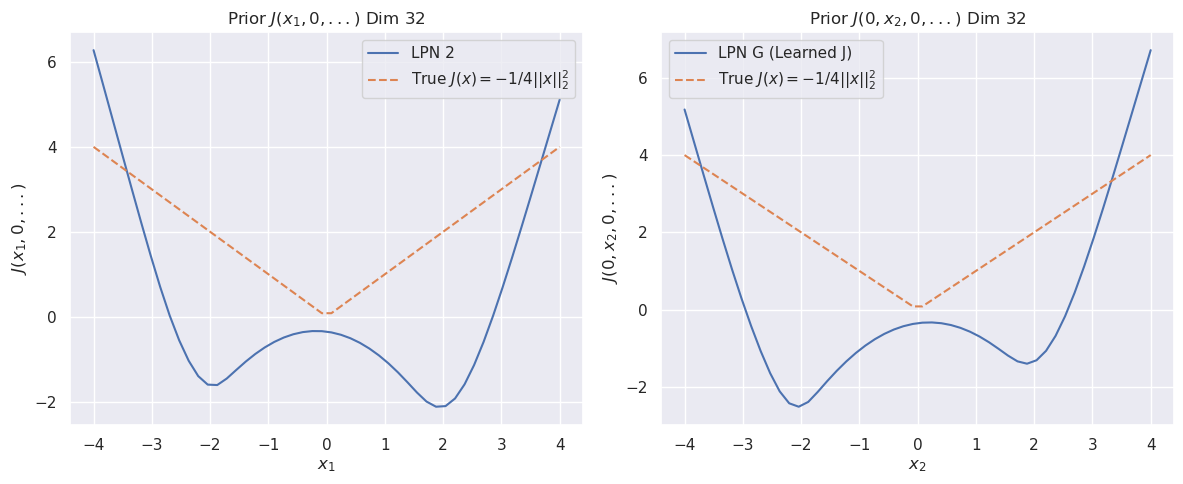

In [15]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_quadratic_l1(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_quadratic_l1(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN G (Learned J)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    #plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)